# Lab ML for DS SS23
## Project 2
#### Jan Jascha Jestel (5547158)
#### Mustafa Suman (5564676)
#### Gabriele Inciuraite (5208806)

In [1]:
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from scipy.io import loadmat
from scipy.spatial.distance import pdist
from scipy.stats import norm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from itertools import combinations_with_replacement, combinations


# 1. Importing the QM7 Dataset

In [2]:
# The QM7 dataset consists of 7165 organic molecules, each of which is composed of up to 23 atoms.
qm7 = loadmat("./qm7.mat")
print(qm7.keys())

dict_keys(['__header__', '__version__', '__globals__', 'X', 'R', 'Z', 'T', 'P'])


In [3]:
# R (7165×23×3) contains for each molecule and atom a triplet representing the 3d coordinates
display(qm7['R'].shape)
display(qm7['R'][0])

(7165, 23, 3)

array([[ 1.886438  , -0.00464873, -0.00823921],
       [ 3.9499245 , -0.00459203,  0.00782347],
       [ 1.1976895 ,  1.9404842 ,  0.00782347],
       [ 1.1849339 , -0.99726516,  1.6593875 ],
       [ 1.2119948 , -0.9589793 , -1.710958  ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.   

In [4]:
# Z (7165×23) contains for each molecule and atom of the molecule the corresponding atomic number

# 0 == no atom at this index
# 1 == hydrogen (H)
# 6 == carbon (C)
# 7 == nitrogen (N) 
# 8 == oxygen (O)
# 16 == sulfur (S)
display(qm7['Z'].shape)
display(qm7['Z'][0])

(7165, 23)

array([6., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.], dtype=float32)

(1, 7165)

-417.96

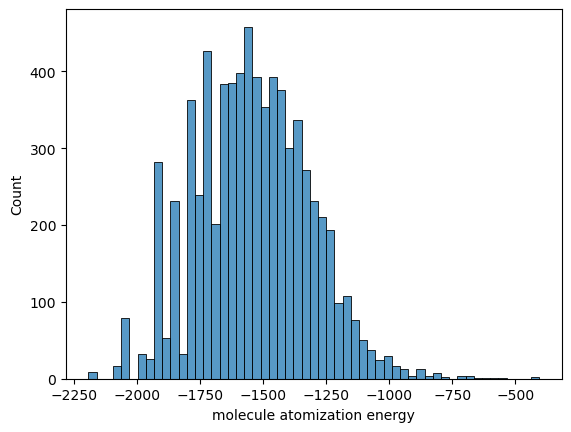

In [5]:
# T (1 x 7165) contains for each molecule the atomization energy (computed via quantum-chemical simulation)
display(qm7['T'].shape)
display(qm7['T'][0, 0])

g = sns.histplot(qm7['T'][0])
g.set_xlabel('molecule atomization energy')
plt.show()

# 1.1 Visualizing Molecules

### "quick and dirty approach"

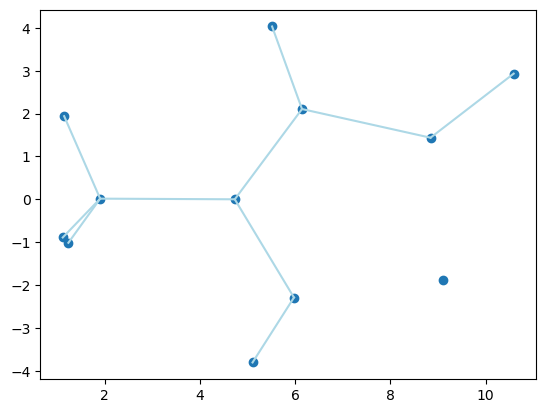

In [6]:
nr = 6432 # TODO describe why fixed threshold might be problemetic (different atoms have different bond lengths)

mol = qm7["R"][nr]
sym = qm7["Z"][nr]

sym = sym[sym > 0]
mol = mol[: len(sym)]

plt.scatter(x=mol[:, 0], y=mol[:, 1])


# generate bonds
thresh = 3

mask = np.argwhere(pdist(mol, metric="euclidean") < thresh)[:, 0]
bonds = np.vstack(np.triu_indices(len(mol), 1)).T[mask]

for i in range(len(bonds)):
    plt.plot(mol[bonds[i]][:, 0], mol[bonds[i]][:, 1], color="lightblue")


### Atomic Simulation Environment

In [7]:
from ase import Atoms
import nglview
import ase.visualize

system = Atoms(positions=mol, symbols=sym)
# ase.visualize.view(system, viewer="x3d")

view = nglview.show_ase(system)
view.add_ball_and_stick() # HOW TO SPECIFY BONDS?????
view

# Other viz approaches
# https://www.kaggle.com/code/mykolazotko/3d-visualization-of-molecules-with-plotly
# nglview

NGLWidget()

# 2. Data Representation, ML Model and Explanations

# 2.1 Data Representation

In [8]:
# one hot encoding of [HCNOS]

# 1 == hydrogen (H)
# 6 == carbon (C)
# 7 == nitrogen (N)
# 8 == oxygen (O)
# 16 == sulfur (S)

z = qm7["Z"].astype(np.int8)

z[z == 1] = 1
z[z == 6] = 2
z[z == 7] = 3
z[z == 8] = 4
z[z == 16] = 5

Z_hot = np.eye(6)[z]
Z_hot = Z_hot[:, :, 1:]  # drop 0 dimension

# sum of to create the representation
x = np.sum(Z_hot, axis=1).astype(int)

print("Shape:", x.shape)
print("Resulting representations:")
print(x)


Shape: (7165, 5)
Resulting representations:
[[ 4  1  0  0  0]
 [ 6  2  0  0  0]
 [ 4  2  0  0  0]
 ...
 [ 9  6  1  0  0]
 [10  7  0  0  0]
 [12  7  0  0  0]]


# 2.2 Ridge Regression Model

In [9]:
def split_and_center(X, y, test_size):
    # split train / test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # center data and target
    X_train_mean = np.mean(X_train, axis=0)
    y_train_mean = np.mean(y_train)

    X_train = X_train - X_train_mean
    X_test = X_test - X_train_mean

    y_train = y_train - y_train_mean
    y_test = y_test - y_train_mean

    return X_train, X_test, y_train, y_test



X_train, X_test, y_train, y_test = split_and_center(x, qm7["T"][0], test_size=0.3)

In [10]:
# Grid search to tune alpha using 10-fold cross validation

ridge = Ridge()
alpha_values = np.logspace(np.log10(1e-4), np.log10(100), num=100)
grid = dict(alpha=alpha_values)
search = GridSearchCV(
    ridge,
    grid,
    scoring=("neg_mean_absolute_error"), # 'r2', 'neg_mean_squared_error'
    cv=10,
    n_jobs=-1,
    refit="neg_mean_absolute_error",
    return_train_score=True,
)  

results = search.fit(X_train, y_train)


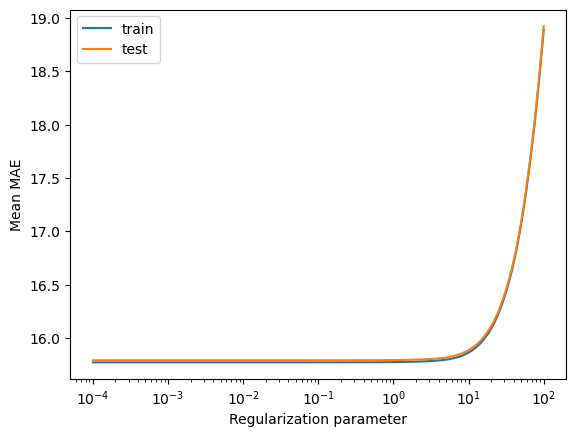

In [11]:
ax = sns.lineplot(x=alpha_values, y = -results.cv_results_['mean_train_score'], label='train')
ax = sns.lineplot(x=alpha_values, y = -results.cv_results_['mean_test_score'], label='test')
ax.set_xscale('log')
ax.set_xlabel('Regularization parameter')
ax.set_ylabel('Mean MAE')
plt.legend(loc='upper left')
plt.show()

In [12]:
# TODO interpretation -> why small alpha always best?
# Why r2 score so high? (already a few examples are sufficient for good test performance)

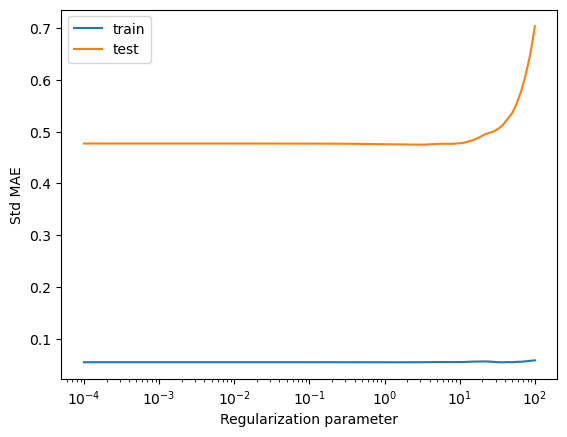

In [13]:
ax = sns.lineplot(x=alpha_values, y = results.cv_results_['std_train_score'], label='train')
ax = sns.lineplot(x=alpha_values, y = results.cv_results_['std_test_score'], label='test')
ax.set_xscale('log')
ax.set_xlabel('Regularization parameter')
ax.set_ylabel('Std MAE')
plt.legend(loc='upper left')
plt.show()

Best parameter: {'alpha': 0.0001}
R2: 0.992
MAE: 15.461
MSE: 403.582


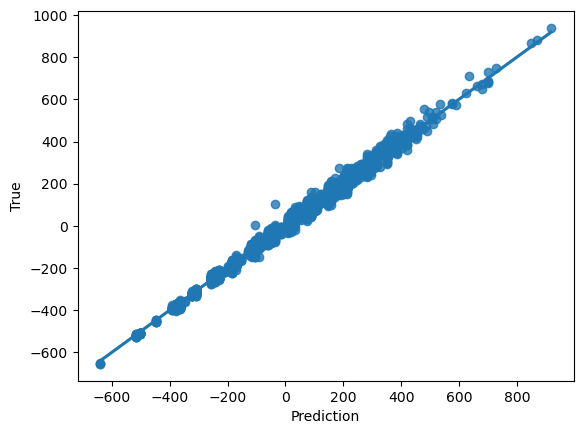

In [14]:
y_pred = search.best_estimator_.predict(X_test)
print("Best parameter:", results.best_params_)
print(f"R2: {r2_score(y_test, y_pred):.3f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.3f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.3f}")
g = sns.regplot(x=y_pred, y=y_test)
g.set_xlabel("Prediction")
g.set_ylabel("True")
plt.show()


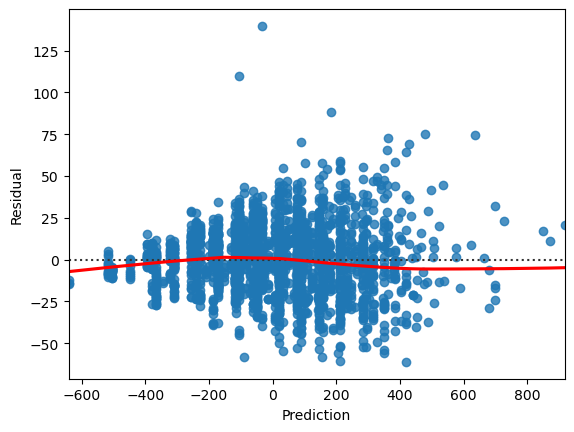

In [15]:
g = sns.residplot(x=y_pred, y=y_test, lowess=True, line_kws=dict(color="r"))
g.set_xlabel("Prediction")
g.set_ylabel("Residual")
plt.show()


In [16]:
# TODO add plot how the weights change with different alpha

# 2.3 Deeper Insights with Explanations 
# 3. Experiments 
# 3.1 Simple atom-based Representation

In [17]:
print(f"MAE: {mean_absolute_error(y_test, search.best_estimator_.predict(X_test)):.3f}")
print("Ri:", search.best_estimator_.coef_)


MAE: 15.461
Ri: [ -68.68727583 -157.410442   -102.41624528 -101.15629173  -80.54594189]


<AxesSubplot: >

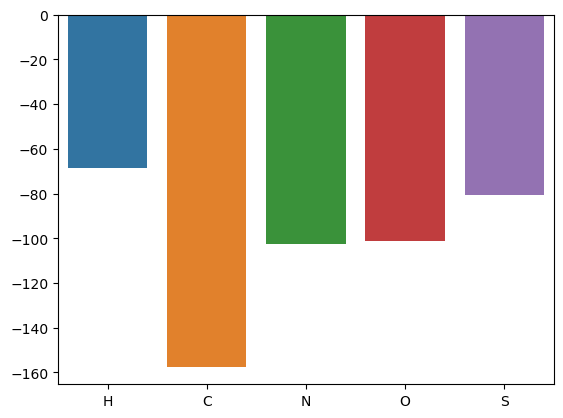

In [18]:
sns.barplot(x=["H", "C", "N", "O", "S"], y=search.best_estimator_.coef_)
# TODO Compare the produced insights with existing chemical knowledge or the literature.

In [19]:
np.mean(x, axis=0)

array([8.6474529 , 4.99106769, 0.92882066, 0.83433357, 0.0414515 ])

In [20]:
np.var(x, axis=0)

array([6.52079079, 0.82280926, 0.62242827, 0.53515059, 0.03973327])

# 3.2 Models with Pairs of Atoms

In [21]:
# create dictionary to translate atom combinations to number between 0 and 14
d = {c: i for i, c in enumerate(combinations_with_replacement([1, 2, 3, 4, 5], r=2))}

# add inverse tuples pointing to same number
inv = {}
for c in d:
    inv[c[1], c[0]] = d[c]

# merge dictionaries
d = d | inv
del inv

In [22]:
# generate arrays with the distances and the types of all pairs
N_COMB = 824783
pair_dist = np.zeros(N_COMB) # all distances
pair_type = np.zeros(N_COMB).astype(int) # all types
mol_split = np.zeros(7165 + 1).astype(int) # indices where to split the array to get the molecules
pair_idx = 0

for i in range(len(z)):
    sym = z[i]
    sym = sym[sym != 0]
    mol = qm7["R"][i][: len(sym)]

    dist = pdist(mol, metric="euclidean")
    comb = [*combinations(sym, r=2)]
    n_combs = len(comb)
    
    pair_dist[pair_idx : pair_idx + n_combs] = dist
    pair_type[pair_idx : pair_idx + n_combs] = [d[x] for x in comb]

    mol_split[i] = pair_idx
    pair_idx += n_combs

mol_split[-1] = N_COMB

In [23]:
def generate_representaions(THETA_1, THETA_M, STD, M, soft = True):

    intervals = np.linspace(THETA_1, THETA_M, M)
    interval_size = (THETA_M - THETA_1) / (M - 1)
    interval_centeres = intervals[:-2] + interval_size

    # generate phi_A(Ei) using specified hard or soft encoding
    phi_A = np.zeros((len(pair_dist), M))

    if soft:
        for j, mu in enumerate(interval_centeres):
            phi_A[:, j] = norm.pdf(pair_dist, loc=mu, scale=STD)
    else: 
        indices = np.floor((pair_dist - THETA_1) / interval_size).astype(int)
        phi_A[indices < M] = np.eye(M)[indices[indices < M]]

    # generate phi_B(Ei)
    phi_B = np.eye(15)[pair_type].astype(int)

    # generate phi(Ei)
    phi_AB = phi_A[:, :, None] * phi_B[:, None, :]
    phi_AB = phi_AB.reshape(N_COMB, -1)

    # aggregate for molecule representation
    reps = np.zeros((len(z), M * 15))
    for i in range(len(mol_split)):
        reps[i - 1, :] = np.sum(phi_AB[mol_split[i - 1] : mol_split[i]], axis=0)
        
    return reps


In [24]:
def plot_pp(model, M, THETA_1, THETA_M):

    # All pairwise potentials plots
    fig, axes = plt.subplots(5, 3, figsize=(12, 20))
    axes = axes.flatten()
    pair_names = [*combinations_with_replacement(["H", "C", "N", "O", "S"], r=2)]
    intervals = np.linspace(THETA_1, THETA_M, M)
    
    for i in range(15):
        g = sns.lineplot(x=intervals, y=model.coef_.reshape(M, 15)[:, i], ax=axes[i])
        g.set_xlabel("Distance")
        g.set_ylabel("Coefficient")
        name = str(pair_names[i]).replace("'", "")
        g.set_title(f"Pairwise potentials {name}")
    plt.tight_layout()

In [25]:
def fit_and_eval_model(Model, ALPHA, X_train, y_train, X_test, y_test,  M, THETA_1, THETA_M):
    model = Model(alpha=ALPHA, max_iter= 10000)
    model.fit(X_train, y_train)

    print(f"MAE: {mean_absolute_error(y_test, model.predict(X_test)):.3f}")
    print(f"#coef = 0: {np.sum(model.coef_ == 0)}")
    print(f"#coef < 1e-10: {np.sum(model.coef_ < 1e-10)}")

    plot_pp(model, M, THETA_1, THETA_M)

# EXPERIMENT **SOFT** encoding (theta range 2 - 8)
**See used parameters below**

In [26]:
THETA_1 = 2
THETA_M = 8
STD = .5
M = 100

ALPHA = 1

reps = generate_representaions(THETA_1, THETA_M, STD, M, soft=True)
X_train, X_test, y_train, y_test = split_and_center(reps, qm7["T"][0], test_size=0.3)

## RIDGE REG

MAE: 7.840
#coef = 0: 128
#coef < 1e-10: 854


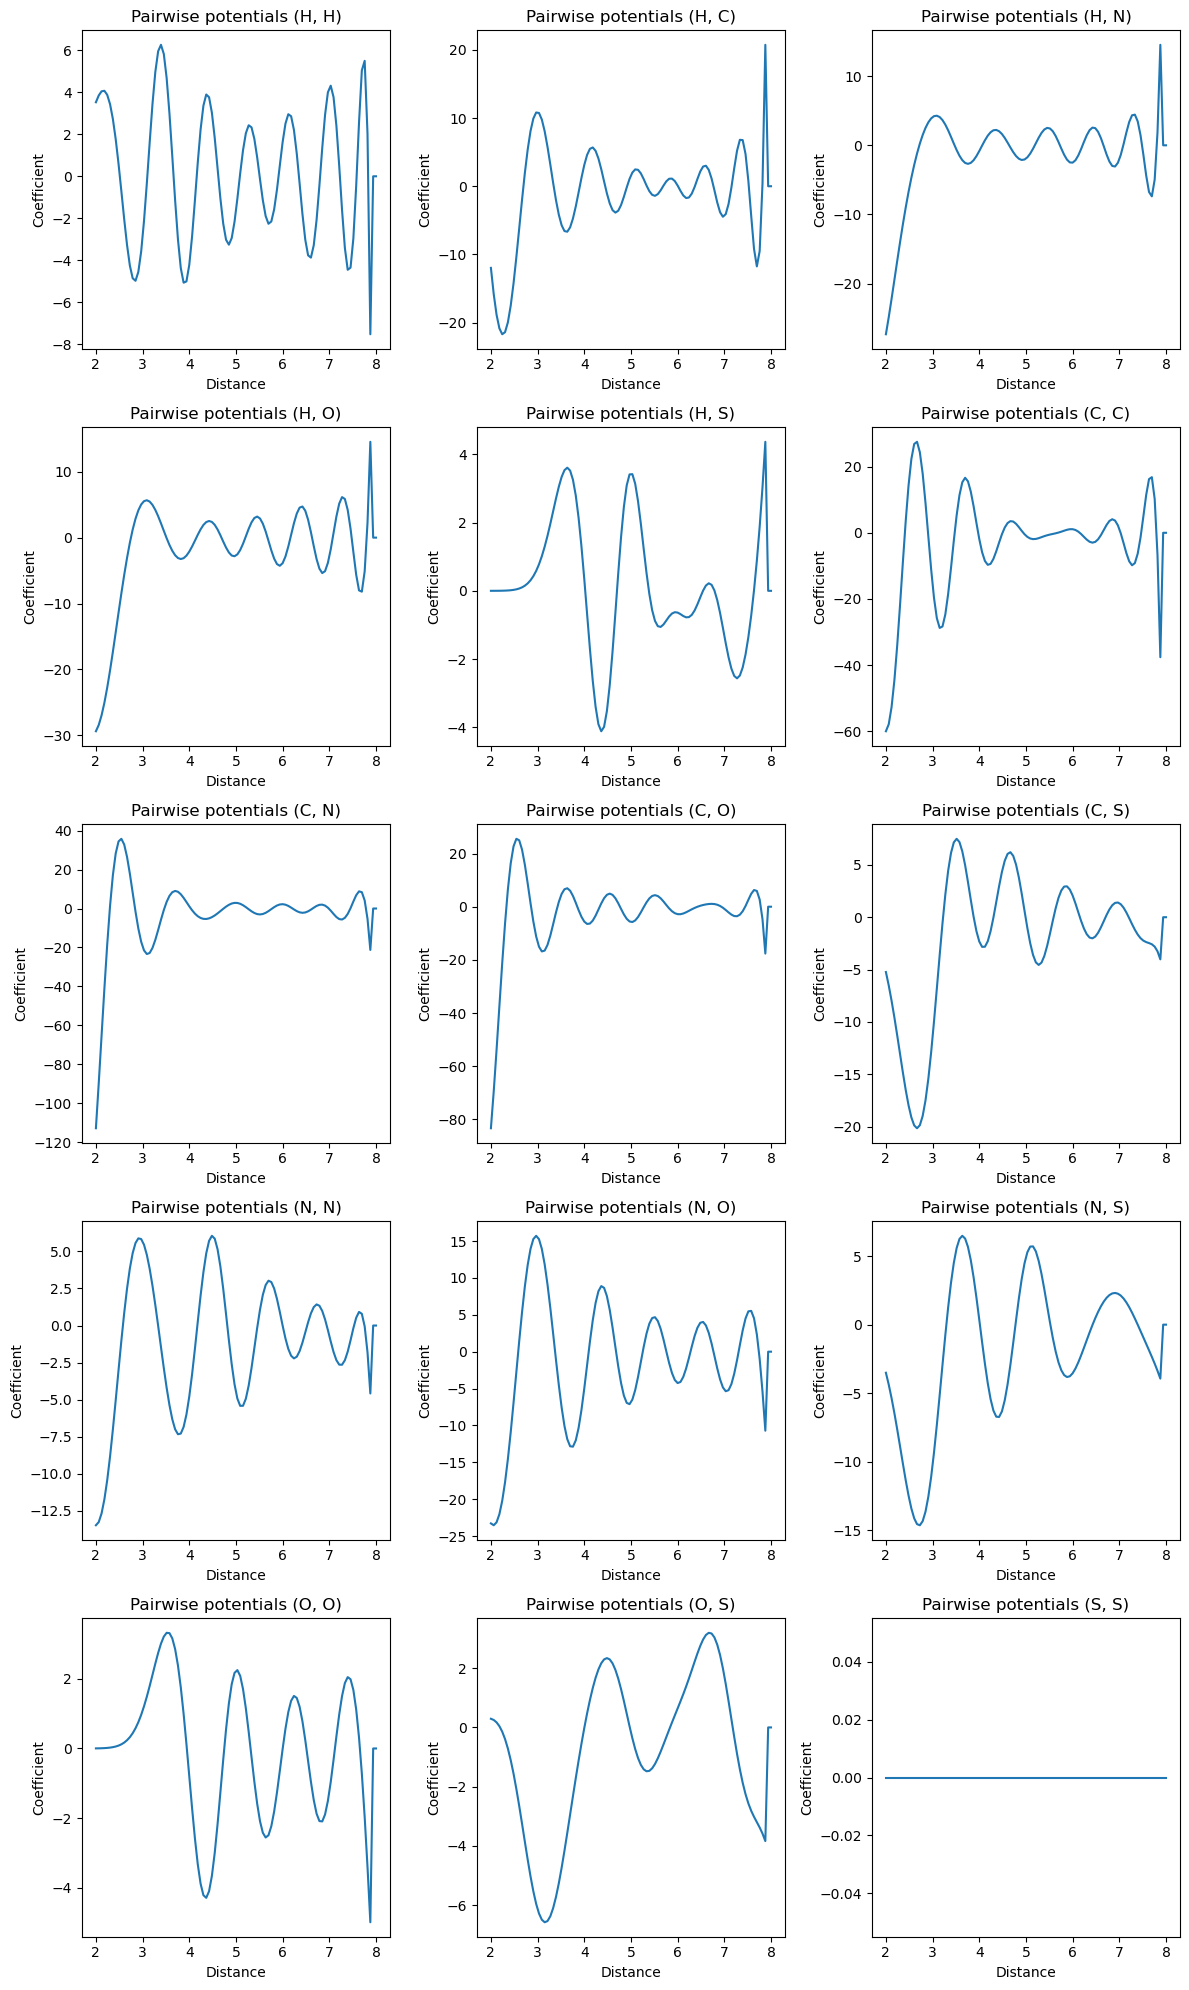

In [27]:
fit_and_eval_model(Ridge, ALPHA, X_train, y_train, X_test, y_test,  M, THETA_1, THETA_M)

## LASSO REG

MAE: 20.435
#coef = 0: 1436
#coef < 1e-10: 1497


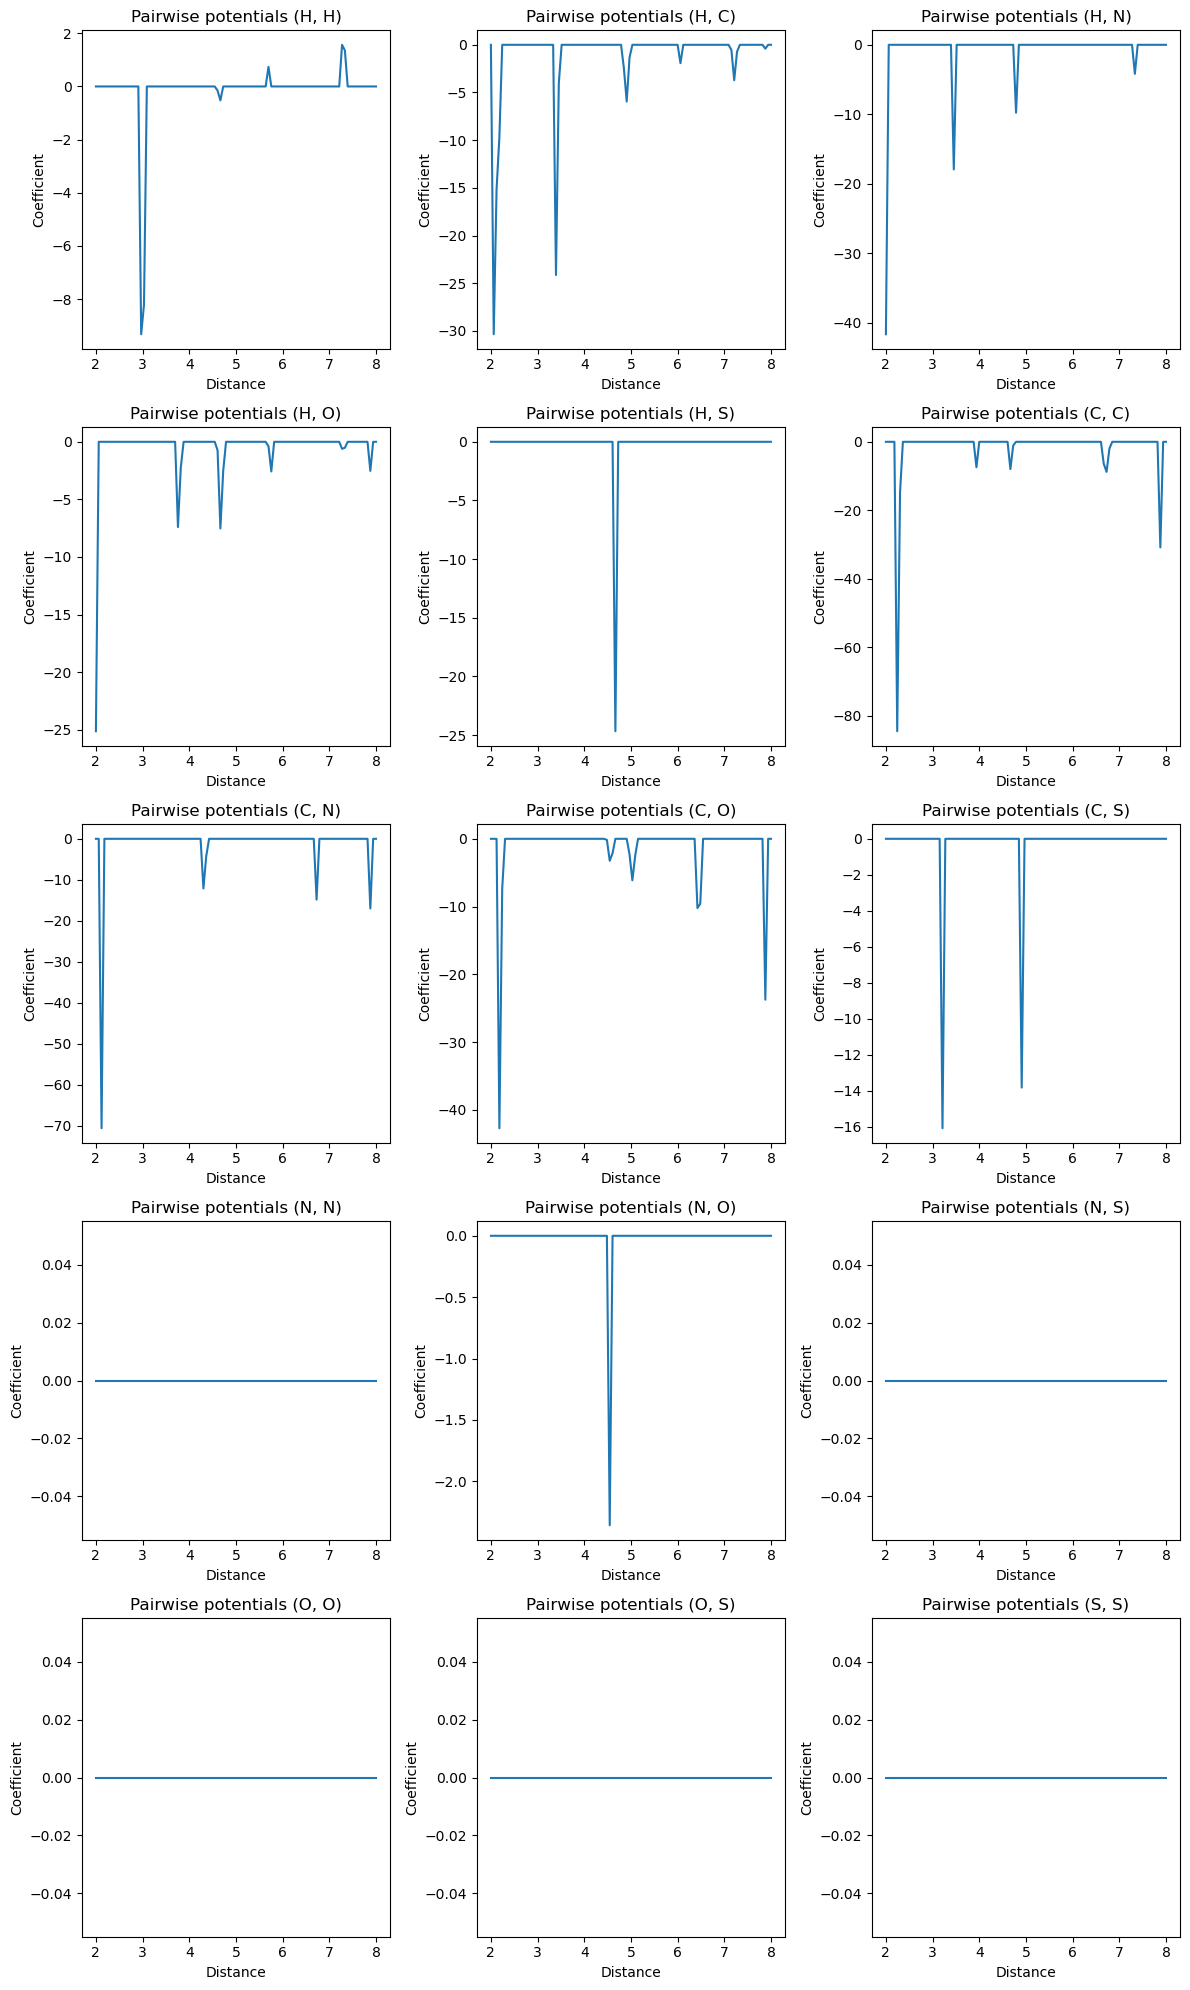

In [28]:
fit_and_eval_model(Lasso, ALPHA, X_train, y_train, X_test, y_test,  M, THETA_1, THETA_M)

# EXPERIMENT **HARD** encoding (same other parameters)

In [29]:
reps = generate_representaions(THETA_1, THETA_M, STD, M, soft=False)
X_train, X_test, y_train, y_test = split_and_center(reps, qm7["T"][0], test_size=0.3)

## RIDGE REG

MAE: 11.921
#coef = 0: 570
#coef < 1e-10: 1303


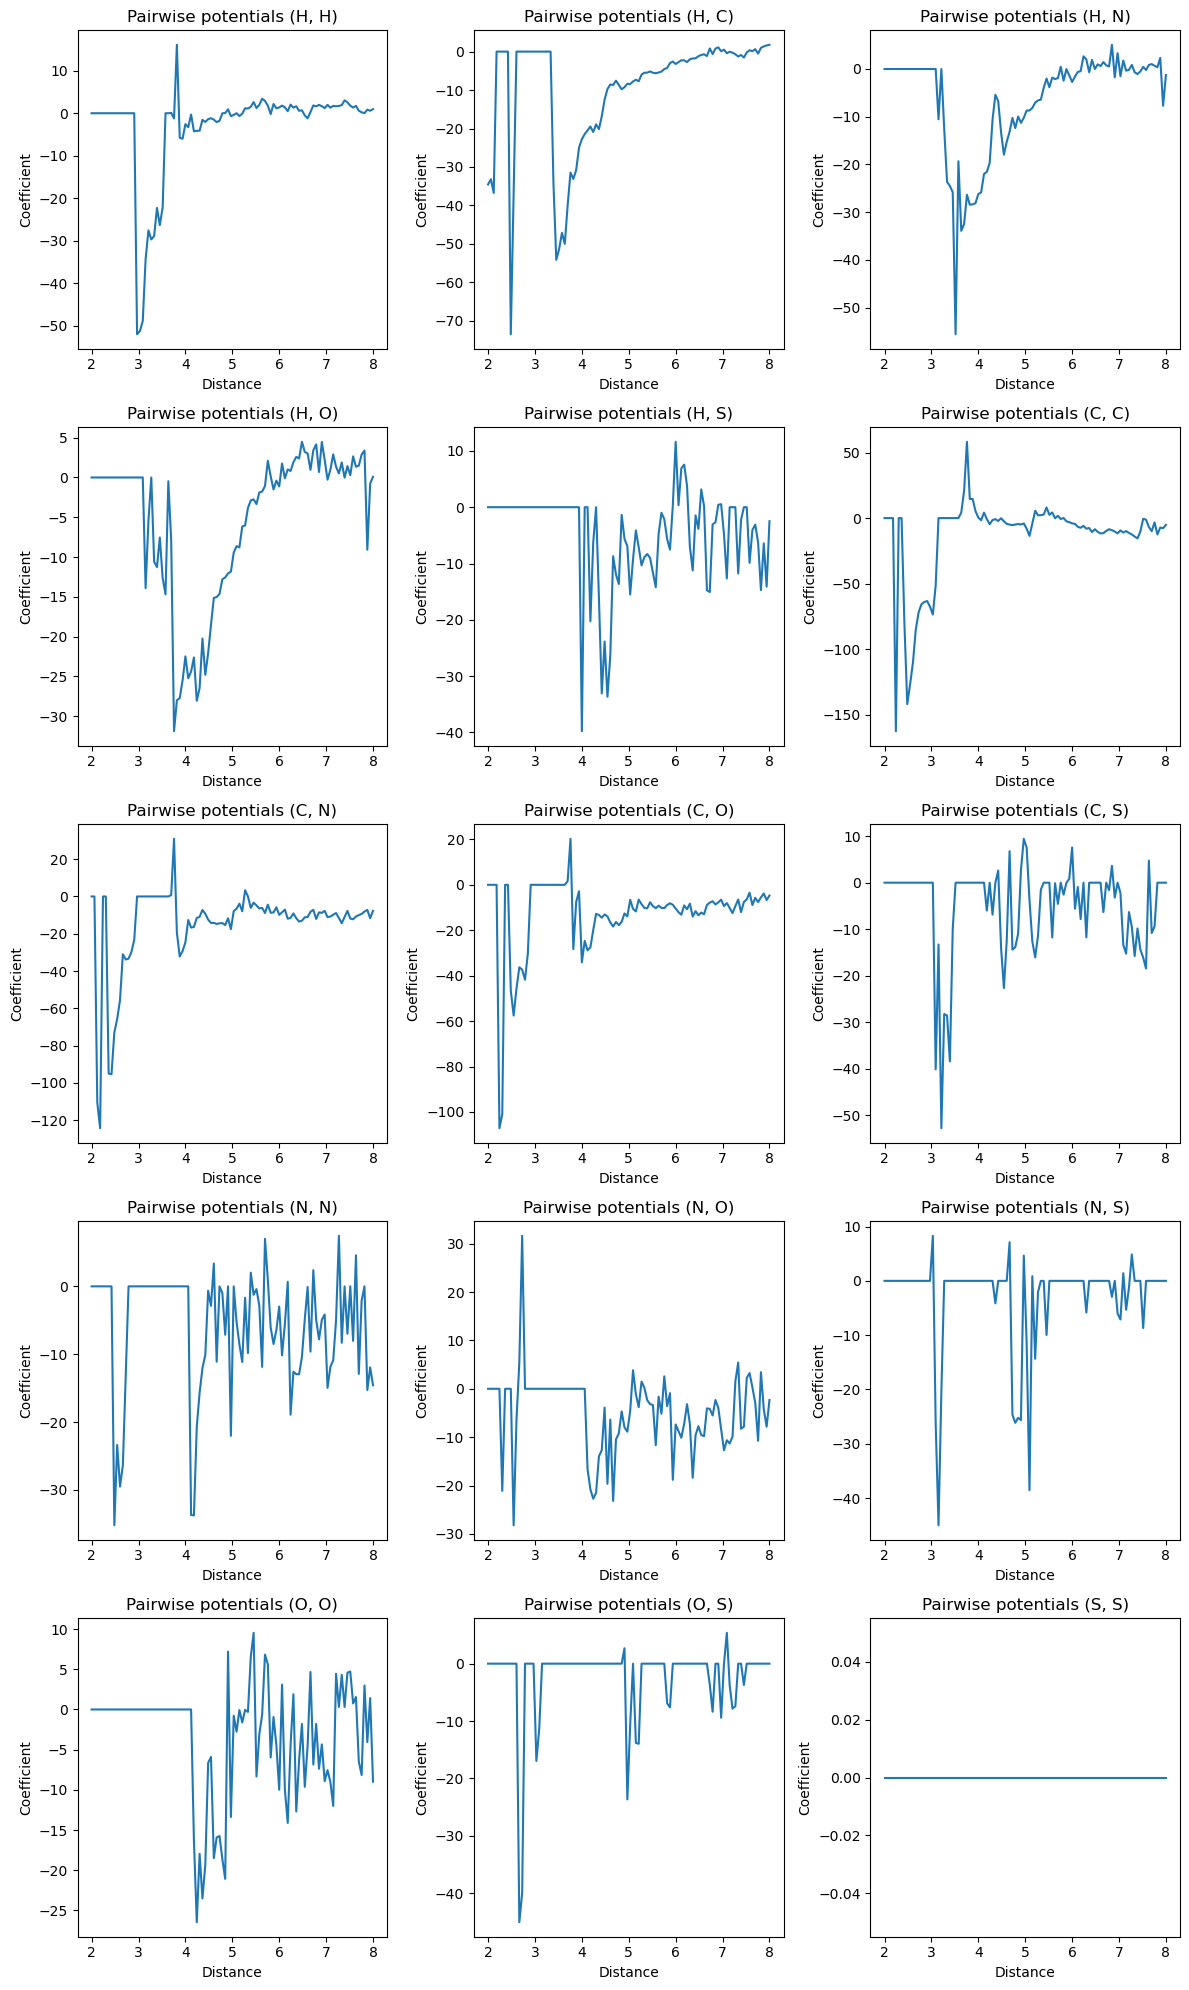

In [30]:
fit_and_eval_model(Ridge, ALPHA, X_train, y_train, X_test, y_test,  M, THETA_1, THETA_M)

## LASSO REG

MAE: 40.020
#coef = 0: 1390
#coef < 1e-10: 1492


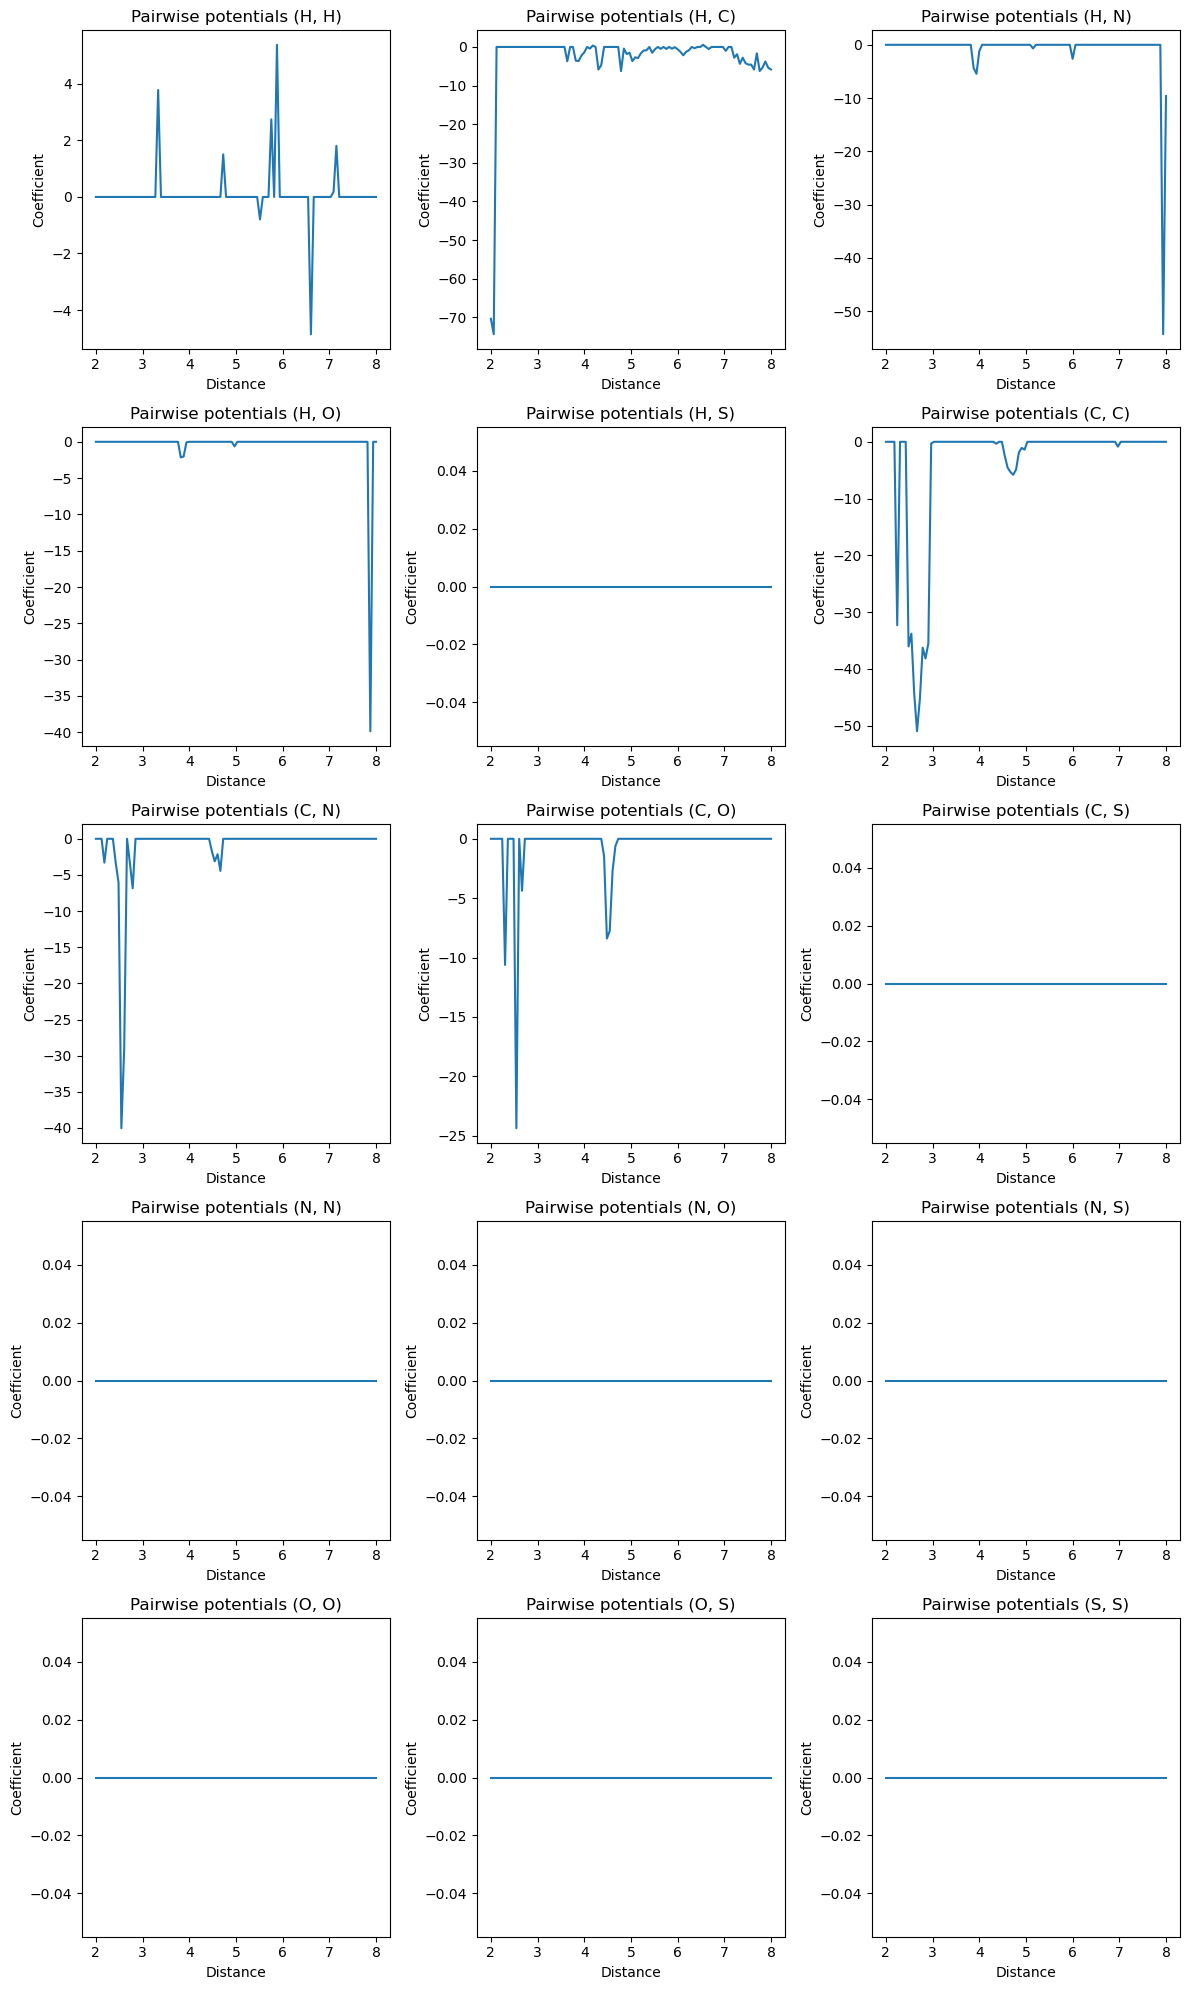

In [31]:
fit_and_eval_model(Lasso, ALPHA, X_train, y_train, X_test, y_test,  M, THETA_1, THETA_M)